# Predicting sentiment_positive with ratings and topics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

import statsmodels.api as sm

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, r2_score
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

## Regression Models on concatenated data

The first two cells are used to aggregate the data. The initial file is 234Mo therefore I only shared with you the aggregated one.

In [227]:
df = pd.read_pickle('reviews_w_topics_test.pkl')

In [228]:
df = df.groupby(['date',
                 'sub_category']).agg({
    'rating':'mean',
    'rating_1':'sum',
    'rating_2':'sum',
    'rating_3':'sum',
    'rating_4':'sum',
    'rating_5':'sum',
    'topic_1':'mean',
    'topic_2':'mean',
    'topic_3':'mean',
    'topic_4':'mean',
    'topic_5':'mean',
    'topic_6':'mean',
    'topic_7':'mean',
    'topic_8':'mean',
    'sentiment_negative':'sum',
    'sentiment_neutral':'sum',
    'sentiment_positive':'sum',
    'sentiment':'mean'
}).reset_index()

In [6]:
df.to_csv('reviews_w_topics_groupedby.csv', index=False)

In [224]:
df = pd.read_csv('reviews_w_topics_groupedby.csv')

In [185]:
y_col = 'sentiment_positive'
X_cols = [
#     'rating', 
#     'rating_1', #Multicolinearity
    'rating_2',
    'rating_3',
    'rating_4',
    'rating_5',
    'topic_1',
    'topic_2',
    'topic_3',
    'topic_4',
    'topic_5',
    'topic_6',
    'topic_7',
    'topic_8']

In [206]:
X = np.log(df[X_cols]+1)
y = np.log(df[y_col]+1)

In [207]:
# Split the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=3)

In [208]:
# Train the model
linreg = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [209]:
# Print results
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:     sentiment_positive   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                 1.536e+04
Date:                Tue, 21 Jul 2020   Prob (F-statistic):               0.00
Time:                        10:55:34   Log-Likelihood:                -78.277
No. Observations:                3325   AIC:                             174.6
Df Residuals:                    3316   BIC:                             229.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8232      0.008     97.140      0.0

In [210]:
# Predict for the test subset
y_pred = linreg.predict(sm.add_constant(X_test))

In [211]:
# Get the out-of-sample R^2
r2_score(y_test, y_pred)

0.9744934558926363

This looks too good to be true. So let's try to change the random seed to try different train/test subsets.

In [212]:
# Lists to store the In-Sample and Out-of-Sample R^2
isr2_list = []
oosr2_list = []
for i in range(10):
    # Split data with different seed
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    # Train model
    linreg = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    # Predict for train and test
    y_train_pred = linreg.predict(sm.add_constant(X_train))
    y_test_pred = linreg.predict(sm.add_constant(X_test))
    # Get In-Sample and Out-of-Sample R^2
    isr2 = r2_score(y_train, y_train_pred)
    oosr2 = r2_score(y_test, y_test_pred)
    print(f'Seed: {i}; In-Sample R^2: {isr2}; Out-of-Sample R^2: {oosr2}')
    # Store the values
    isr2_list.append(isr2)
    oosr2_list.append(oosr2)
# Get the average In-Sample and Out-of-Sample R^2
print(f'\nAverage In-Sample R^2: {np.mean(isr2_list)}; Average Out-of-Sample R^2: {np.mean(oosr2_list)}')

Seed: 0; In-Sample R^2: 0.9738705612797196; Out-of-Sample R^2: 0.9743044148700007
Seed: 1; In-Sample R^2: 0.9741121408304256; Out-of-Sample R^2: 0.9736970850623755
Seed: 2; In-Sample R^2: 0.9737544060885662; Out-of-Sample R^2: 0.9744669731932042
Seed: 3; In-Sample R^2: 0.973721963063949; Out-of-Sample R^2: 0.9744934558926363
Seed: 4; In-Sample R^2: 0.9739756748246818; Out-of-Sample R^2: 0.974027946769128
Seed: 5; In-Sample R^2: 0.9732477880921723; Out-of-Sample R^2: 0.9752877887126598
Seed: 6; In-Sample R^2: 0.9738625902298673; Out-of-Sample R^2: 0.9742782481840315
Seed: 7; In-Sample R^2: 0.9736935440018794; Out-of-Sample R^2: 0.9746662837427775
Seed: 8; In-Sample R^2: 0.973914953042606; Out-of-Sample R^2: 0.9742060366390741
Seed: 9; In-Sample R^2: 0.9740915230007259; Out-of-Sample R^2: 0.9737664261741343

Average In-Sample R^2: 0.9738245144454591; Average Out-of-Sample R^2: 0.9743194659240022


Still suspiciously good results... Let's try just the topics:

In [229]:
y_col = 'sentiment_positive'
X_cols = [
#     'rating', 
#     'rating_1', 
#     'rating_2',
#     'rating_3',
#     'rating_4',
#     'rating_5',
    'topic_1',
    'topic_2',
    'topic_3',
    'topic_4',
    'topic_5',
    'topic_6',
    'topic_7',
    'topic_8'
]

In [230]:
X = df[X_cols]
y = np.log(df[y_col]+1)

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

In [232]:
linreg = sm.OLS(y_train, sm.add_constant(X_train)).fit()

In [233]:
print(linreg.summary())

                            OLS Regression Results                            
Dep. Variable:     sentiment_positive   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     34.18
Date:                Tue, 21 Jul 2020   Prob (F-statistic):           3.07e-52
Time:                        10:57:33   Log-Likelihood:                -6014.1
No. Observations:                3325   AIC:                         1.205e+04
Df Residuals:                    3316   BIC:                         1.210e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.8917      4.984     11.215      0.0

In [234]:
y_pred = linreg.predict(sm.add_constant(X_test))

In [235]:
r2_score(y_test, y_pred)

0.0768575673295413

Again this is too good to be true. Let's check the values.

In [236]:
y_test

2153    0.606136
2677    4.808962
696     1.952239
202     0.916291
483     3.894260
          ...   
2449    3.094068
1350    5.946382
4628    2.215574
2714    4.567814
4900    4.489167
Name: sentiment_positive, Length: 1638, dtype: float64

In [237]:
y_pred

2153    2.931268
2677    3.088655
696     2.937641
202     2.786228
483     2.723577
          ...   
2449    3.060835
1350    2.865023
4628    2.925158
2714    2.860897
4900    3.250151
Length: 1638, dtype: float64

Pretty similar. Let's check the correlation matrix

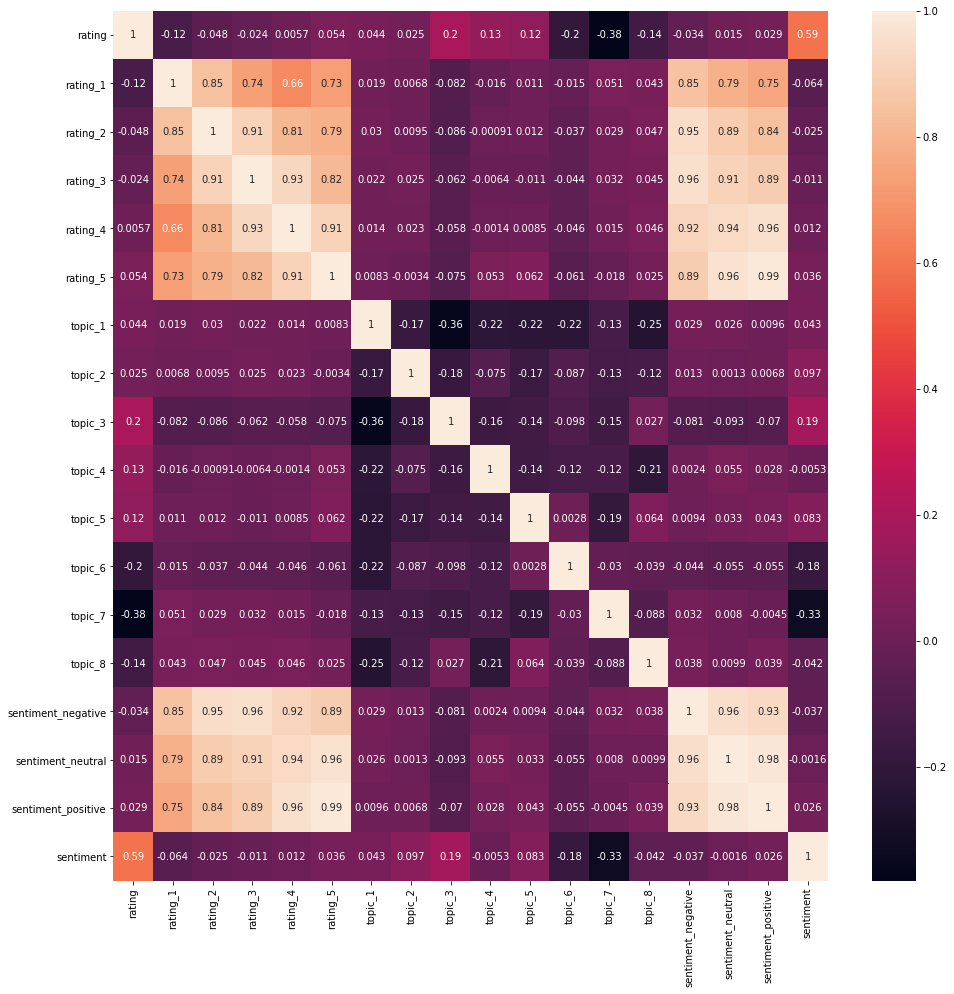

In [238]:
plt.figure(figsize=(16,16))
sn.heatmap(df.corr(), annot=True)

sentiment_positive is correlated to the rest of the variables. This is because we are summing when doing the aggregation.

Let's transform the sentiment to proportions.

In [92]:
df[['sentiment_negative', 'sentiment_neutral', 'sentiment_positive']].divide(df[['sentiment_negative', 'sentiment_neutral', 'sentiment_positive']].sum(axis=1), axis=0)

,sentiment_negative,sentiment_neutral,sentiment_positive
0,0.022789,0.125544,0.851667
1,0.030387,0.113029,0.856584
2,0.057372,0.114775,0.827853
3,0.500000,0.500000,0.000000
4,0.000000,0.000000,1.000000
...,...,...,...
4958,0.080337,0.174001,0.745662
4959,0.067500,0.107976,0.824524
4960,0.000000,0.000000,1.000000
4961,0.117706,0.160280,0.722015


We see that most of the rows are sentiment positive. So I am pretty sure sentiment_positive is pretty correlated to the number of reviews. The same goes for the ratings and the topics... The bigger each one of the feature is, the more reviews we have, and the higher is going to be sentiment_positive.

# Appendix

## Models Multi-Label classification

In [4]:
df = pd.read_pickle('reviews_w_topics_test.pkl')

In [22]:
df.columns

Index(['type', 'channel', 'source_product_identifier', 'date', 'onlinepost_id',
       'description', 'nb_statements', 'rating', 'rating_1', 'rating_2',
       'rating_3', 'rating_4', 'rating_5', 'sentiment_negative',
       'sentiment_neutral', 'sentiment_positive', 'sentiment', 'tokens',
       'product', 'brand_abbrev', 'elc_brand', 'brand_score',
       'item_description', 'product_score', 'itemid_4', 'major_category_id',
       'major_category', 'application_id', 'application', 'category_id',
       'category', 'sub_category_id', 'sub_category', 'topic_1', 'topic_2',
       'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8',
       'sentiment_cat'],
      dtype='object')

In [5]:
df['sentiment_cat'] = np.round(df['sentiment'])

In [13]:
y_col = 'sentiment_cat'
X_cols = [
#     'rating', 
#     'rating_1', 
    'rating_2',
    'rating_3',
    'rating_4',
    'rating_5',
    'topic_1',
    'topic_2',
    'topic_3',
    'topic_4',
    'topic_5',
    'topic_6',
    'topic_7',
    'topic_8']
classes = {1:'positive',
           0:'neutral',
           -1:'negative'}

In [14]:
X = df[X_cols]
y = label_binarize(df[y_col], classes=list(classes.keys()))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df['sentiment_cat'], random_state=3)

In [3]:
def calculate_plot_roc(y_test, y_score, classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw = 2
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = roc_auc_score(y_test, y_score, average='micro', multi_class='ovo', labels=classes)

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= len(classes)

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = roc_auc_score(y_test, y_score, average='macro', multi_class='ovo', labels=classes)

    # Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i],  lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(list(classes.values())[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    return {'fpr':fpr, 'tpr':tpr, 'roc_auc':roc_auc}

In [15]:
evaluation = {}

### Logistic Regression

In [16]:
logreg = sm.MNLogit(y_train, sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.472389
         Iterations 11


In [17]:
print(logreg.summary())

                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:               310445
Model:                        MNLogit   Df Residuals:                   310419
Method:                           MLE   Df Model:                           24
Date:                Mon, 20 Jul 2020   Pseudo R-squ.:                  0.1832
Time:                        13:06:34   Log-Likelihood:            -1.4665e+05
converged:                       True   LL-Null:                   -1.7955e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
       y=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.2144      0.506    -16.235      0.000      -9.206      -7.223
rating_2      -0.4111      0.025    -16.583      0.000      -0.460      -0.363
rating_3      -0.9339      0.022    -42.438      0.0

In [18]:
y_score = logreg.predict(sm.add_constant(X_test)).values

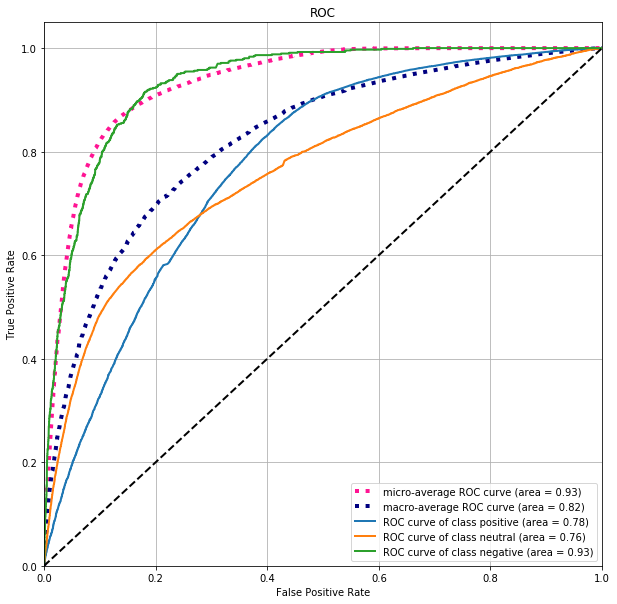

In [19]:
evaluation['Logistic'] = calculate_plot_roc(y_test, y_score, classes=classes)

### SVM

In [ ]:
sample = df.sample(10000, random_state=3)
X = sample[X_cols]
y = label_binarize(sample[y_col], classes=list(classes.keys()))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=sample['sentiment_cat'], random_state=3)

In [ ]:
param_grid = [
  {'estimator__C': [1, 10, 100], 'estimator__kernel': ['linear']},
  {'estimator__C': [1, 10, 100], 'estimator__gamma': [‘scale’, ‘auto’], 'estimator__kernel': ['rbf', 'poly']},
 ]

In [ ]:
model = OneVsRestClassifier(svm.SVC())
grid = GridSearchCV(model, param_grid, verbose=10, n_jobs=-1, cv=2).fit(X_train, y_train)

In [ ]:
y_score = grid.predict(X_test)

In [ ]:
evaluation['SVM'] = calculate_plot_roc(y_test, y_score, classes=classes)

### CART